* **[Phase 1 - Data Collection and Visualization](#phase1)**
   - [Imports & Installations](#import)
   - [Data Loading](#step01)   
   - [Data Parsing & Cleaning](#step02)  
   - [Data Flattening](#step03)  
   - [Exporting Data to Excel](#step04)  

* **[Phase 2 - Data Storage and Processing Pipeline](#phase2)**
   - [Section 1: Database Implementation and Data Querying](#p2step1)
* **[Phase 3 - Final Conclusions and Model Development](#phase3)**


<a id='phase1'></a>
## **Phase 1 - Data Collection and Visualization**

<a id='import'></a>
### **Imports & Installations**

In [1]:
# !pip install kagglehub
# !pip install openpyxl

In [2]:
import xml.etree.ElementTree as ET
import kagglehub
import os
import pandas as pd

<a id='step01'></a>
### **Data Loading**

In [3]:
path_to_dataset = "content"
"""
If the dataset is not downloaded to your local machine you can use the following
commented command:
"""
# path_to_dataset = kagglehub.dataset_download("andrewmvd/car-plate-detection")

annotation_folder = os.path.join(path_to_dataset, "annotations")
image_folder = os.path.join(path_to_dataset, "images")

<a id='step02'></a>
### **Data Parsing & Cleaning**

In [4]:
def parse_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    size = {
        'width': root.find('size/width').text,
        'height': root.find('size/height').text
    }
        
    objects = [{
            'bndbox': {
                'xmin': object.find('bndbox/xmin').text,
                'ymin': object.find('bndbox/ymin').text,
                'xmax': object.find('bndbox/xmax').text,
                'ymax': object.find('bndbox/ymax').text,
            }
        } for object in root.findall('object')]
           
    extracted_info = {
        'folder': root.find('folder').text,
        'filename': root.find('filename').text,
        'size': size,
        'objects': objects
    }
    
    return extracted_info 


<a id='step03'></a>
### **Data Flattening**

In [5]:
records = []
for file in os.listdir(annotation_folder):
    if file.endswith(".xml"):
        data = parse_xml(os.path.join(annotation_folder, file))
        for obj in data["objects"]:
            row = {
                "filename": data["filename"],
                "folder": data["folder"],
                "width": int(data["size"]["width"]),
                "height": int(data["size"]["height"]),
                "xmin": int(obj["bndbox"]["xmin"]),
                "ymin": int(obj["bndbox"]["ymin"]),
                "xmax": int(obj["bndbox"]["xmax"]),
                "ymax": int(obj["bndbox"]["ymax"])
            }
            records.append(row)


<a id='step04'></a>
### **Exporting Data to Excel**

In [6]:
df = pd.DataFrame(records)
excel_path = "car_plate_annotations.xlsx"
df.to_excel(excel_path, index=False)

print(f"Data exported successfully to {excel_path}")

Data exported successfully to car_plate_annotations.xlsx


<a id='phase2'></a>
## **Phase 2 - Data Storage and Processing Pipeline**

<a id='p2step1'></a>
### **Section 1: Database Implementation and Data Querying**


#### **creating database and importing data to database**
["import_to_db"](import_to_db.py)

#### **Database Queries and Explorations**

In [61]:
import sqlite3
import pandas as pd


conn = sqlite3.connect('car_plates.db')
cursor = conn.cursor()

# Query 1: General data overview (first 20 records)
print("\n=== GENERAL DATA OVERVIEW (first 20 records) ===")
cursor.execute("SELECT * FROM car_plates LIMIT 20")
general_data = cursor.fetchall()
for row in general_data:
    print(row)

# Query 2: Top 15 biggest plates by area
print("\n=== TOP 15 BIGGEST PLATES BY AREA ===")
cursor.execute("""
    SELECT filename, (xmax-xmin)*(ymax-ymin) as area 
    FROM car_plates 
    ORDER BY area DESC 
    LIMIT 15
""")
top_plates = cursor.fetchall()
for plate in top_plates:
    print(f"File: {plate[0]}, Area: {plate[1]} pixels")

# Query 3: Top 10 largest pictures overall (by image dimensions)
print("\n=== TOP 10 LARGEST PICTURES (BY DIMENSIONS) ===")
cursor.execute("""
    SELECT filename, width, height 
    FROM car_plates 
    ORDER BY (width * height) DESC 
    LIMIT 10
""")
big_pics = cursor.fetchall()
for pic in big_pics:
    print(f"File: {pic[0]}, Size: {pic[1]}x{pic[2]} pixels")


# Query 4: Plates with small aspect ratios (potential anomalies)
print("\n=== PLATES WITH UNUSUAL ASPECT RATIOS (<0.5) ===")
cursor.execute("""
    SELECT filename, 
           (xmax-xmin)/(ymax-ymin) as aspect_ratio
    FROM car_plates
    WHERE (xmax-xmin)/(ymax-ymin) < 0.5
    ORDER BY ABS(1.0 - (xmax-xmin)/(ymax-ymin)) DESC LIMIT 10
""")
weird_plates = cursor.fetchall()
for plate in weird_plates:
    print(f"File: {plate[0]}, Aspect Ratio: {plate[1]:.2f}")

conn.close()


=== GENERAL DATA OVERVIEW (first 20 records) ===
(0, 'Cars0.png', 'images', 500, 268, 226, 125, 419, 173, 'content/images/Cars0.png')
(1, 'Cars1.png', 'images', 400, 248, 134, 128, 262, 160, 'content/images/Cars1.png')
(2, 'Cars10.png', 'images', 400, 225, 140, 5, 303, 148, 'content/images/Cars10.png')
(3, 'Cars100.png', 'images', 400, 267, 175, 114, 214, 131, 'content/images/Cars100.png')
(4, 'Cars101.png', 'images', 400, 300, 167, 202, 240, 220, 'content/images/Cars101.png')
(5, 'Cars102.png', 'images', 350, 263, 66, 147, 322, 199, 'content/images/Cars102.png')
(6, 'Cars103.png', 'images', 400, 196, 230, 129, 248, 134, 'content/images/Cars103.png')
(7, 'Cars103.png', 'images', 400, 196, 189, 116, 202, 121, 'content/images/Cars103.png')
(8, 'Cars104.png', 'images', 500, 374, 195, 266, 244, 282, 'content/images/Cars104.png')
(9, 'Cars105.png', 'images', 400, 240, 152, 147, 206, 159, 'content/images/Cars105.png')
(10, 'Cars106.png', 'images', 400, 247, 138, 79, 177, 92, 'content/images

<a id='p2step1'></a>
### **Section 2: Advanced Feature Engineering, Data Preprocessing, and Preparation for Modeling**

#### **Review Initial Insights (EDA)**
IIIIIIIIIIIIIIIIIII NEED TO DO THIS LATER

#### **Perform Advanced Feature Engineering**:



##### **extracting general measures**:
some general metrics were calculated for each image.

In [62]:
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
import numpy as np

conn = sqlite3.connect('car_plates.db')

df = pd.read_sql_query("SELECT * FROM car_plates", conn)
conn.close()

def calculate_features(df):
    df['plate_width'] = df['xmax'] - df['xmin']
    df['plate_height'] = df['ymax'] - df['ymin']
    
    df['plate_aspect_ratio'] = df['plate_width'] / df['plate_height']
    df['image_aspect_ratio'] = df['width'] / df['height']
    
    df['width_ratio'] = df['plate_width'] / df['width']
    df['height_ratio'] = df['plate_height'] / df['height']
    df['area_ratio'] = (df['plate_width'] * df['plate_height']) / (df['width'] * df['height'])


    df['x_center'] = ((df['xmax'] + df['xmin']) / 2) / df['width']
    df['y_center'] = ((df['ymax'] + df['ymin']) / 2) / df['height']





    df['center_distance'] = np.sqrt((df['x_center']-0.5)**2 + (df['y_center']-0.5)**2)
    df['min_x_distance'] = np.minimum(df['xmin'], df['width'] - df['xmax']) / df['width']
    df['min_y_distance'] = np.minimum(df['ymin'], df['height'] - df['ymax']) / df['height']
    
    return df

df = calculate_features(df)

##### **classified images**:
classified images in three categories, partial which means plate occupies small part of the image and full which means most of the image is occupied and problemtics are pictures that have a bad ratio

Plate Type Distribution:
plate_type
partial    0.779193
problem    0.195329
full       0.025478
Name: proportion, dtype: float64


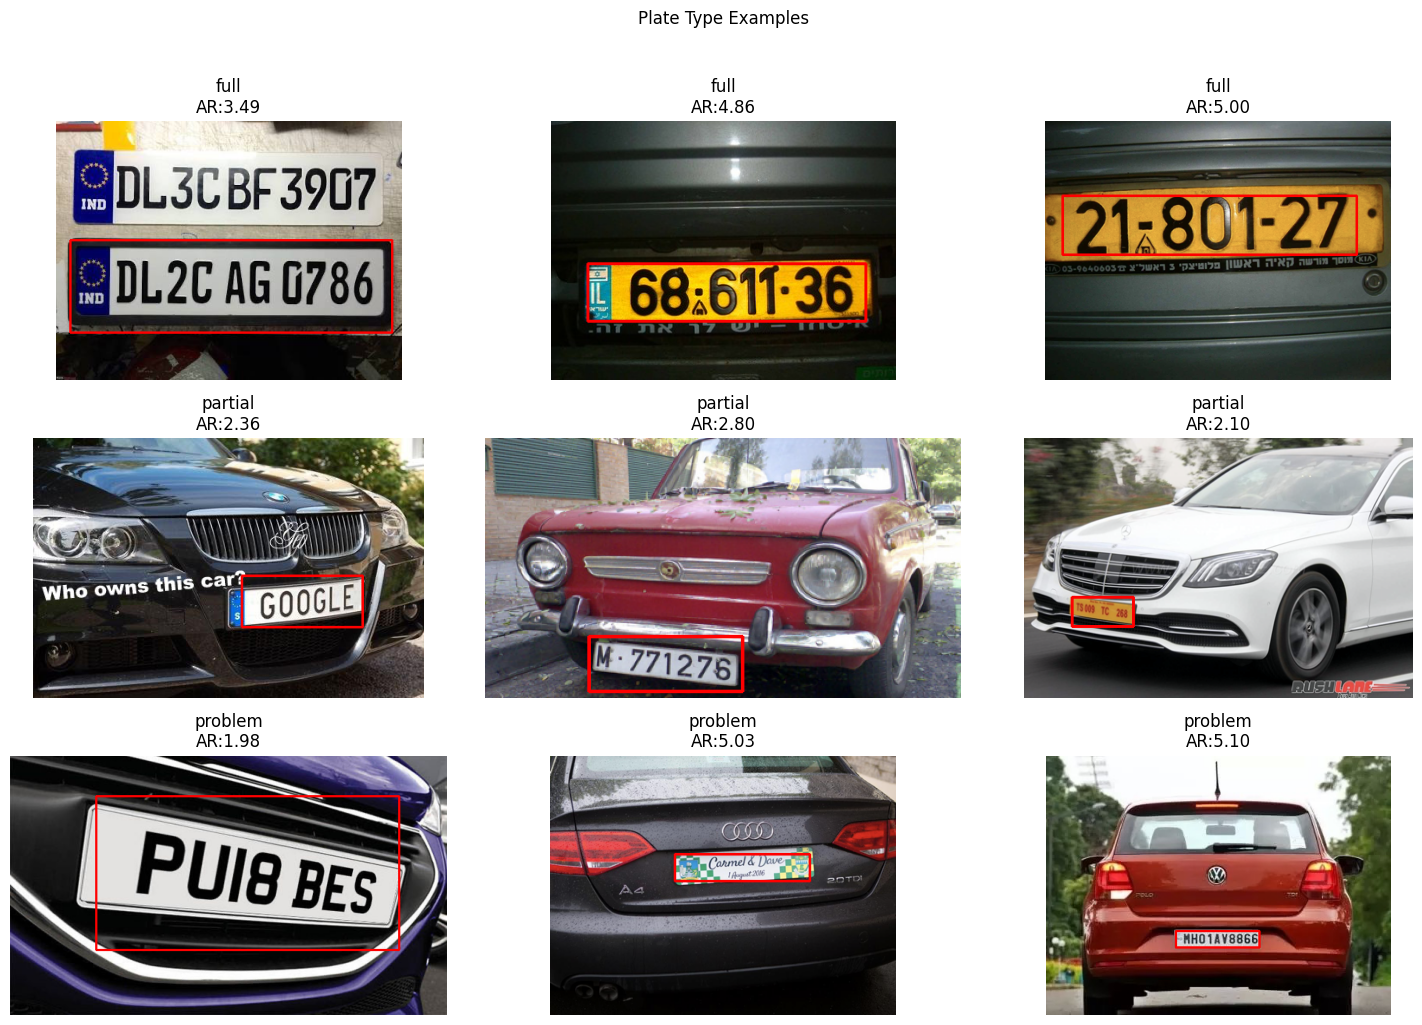

In [ ]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def classify_plates(df):
    full_plate_mask = (
        (df['width_ratio'] > 0.7) | 
        (df['height_ratio'] > 0.7)
    )
    
    partial_plate_mask = (
        (df['plate_aspect_ratio'].between(1.5, 5.0)) &
        (df['width_ratio'].between(0.05, 0.5)) & 
        (df['height_ratio'].between(0.03, 0.3)) 
    )
    

    problem_plate_mask = ~(full_plate_mask | partial_plate_mask)
    
    df['plate_type'] = np.select(
        [full_plate_mask, partial_plate_mask, problem_plate_mask],
        ['full', 'partial', 'problem'],
        default='unknown'
    )
    return df

df = classify_plates(df)
print("Plate Type Distribution:")
print(df['plate_type'].value_counts(normalize=True))

def show_samples(df, n=3):
    fig, axes = plt.subplots(3, n, figsize=(15, 10))
    plt.suptitle("Plate Type Examples", y=1.02)
    
    for i, plate_type in enumerate(['full', 'partial', 'problem']):
        samples = df[df['plate_type'] == plate_type].sample(min(n, len(df)))
        
        for j, (_, row) in enumerate(samples.iterrows()):
            img_path = row['image_path']
            img = cv2.imread(str(img_path))
            if img is None:
                print(f"Error: Image at {img_path} not found or unable to load.")

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
            
            axes[i,j].imshow(img)
            axes[i,j].set_title(f"{plate_type}\nAR:{row['plate_aspect_ratio']:.2f}")
            axes[i,j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(df)


AttributeError: 'NoneType' object has no attribute 'copy'

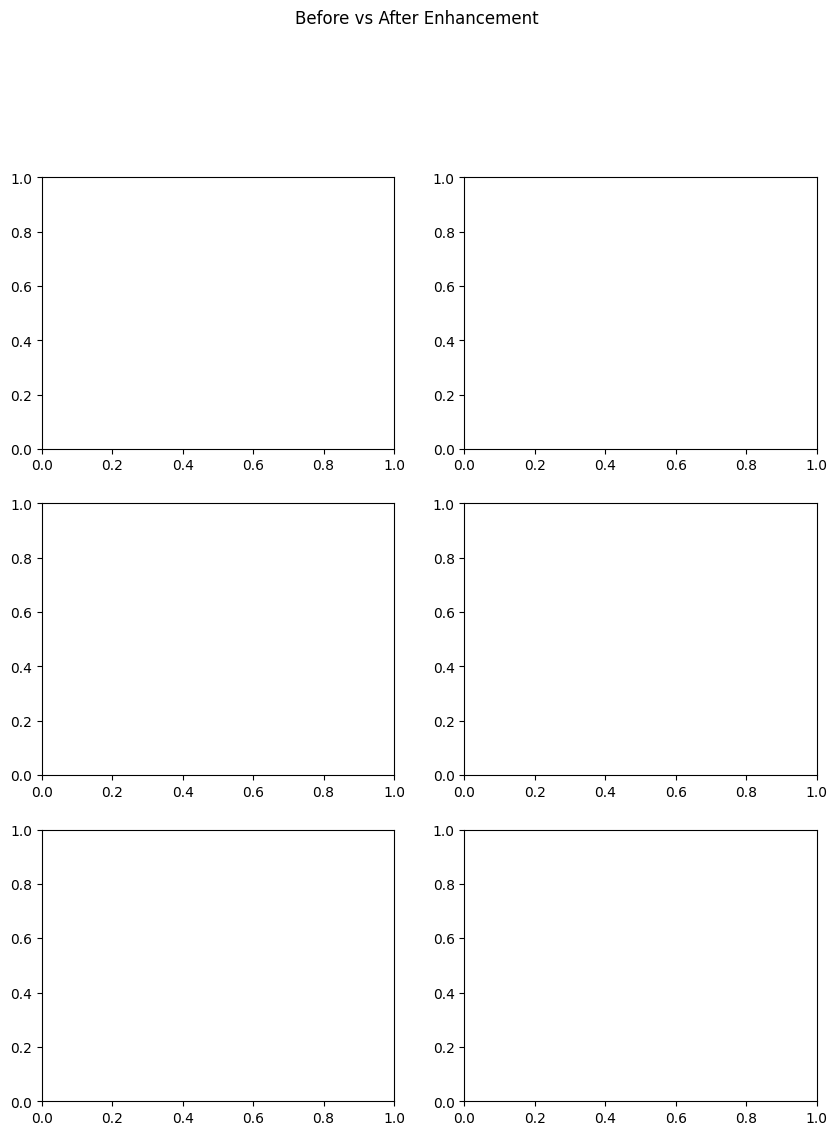

<a id='phase3'></a>
## **Phase 3 - Final Conclusions and Model Development**